In [1]:
import numpy as np
import pandas as pd
import gensim
from gensim import models
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import time
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
import warnings
from gensim import corpora
import scipy.stats as stats
from scipy.spatial import distance
from scipy.stats import skew, kurtosis
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
warnings.filterwarnings("ignore")

In [2]:
#词向量特征
#词向量训练的回调函数，用来打印loss、保存模型等等（注意，即使不训练词向量，加载时也要载入这个类）
class train_log_word(gensim.models.callbacks.CallbackAny2Vec):
    def __init__(self, savename):
        self.loss = []
        self.time = 0.0
        self.epoch = 0
        self.savename = savename
    #在每一轮开始的时候
    def on_epoch_begin(self,model):
        self.time = time.time()
    #在每一轮结束的时候
    def on_epoch_end(self,model):
        self.epoch+=1
        print('Epoch '+str(self.epoch)+' using time '+str(time.time()-self.time)+' seconds')
        #这个loss似乎是总的loss叠加
        print('loss: '+str(model.get_latest_training_loss()))
        self.loss.append(model.get_latest_training_loss())
        #5轮保存一次
        if(self.epoch%5==0):
            model.save(self.savename)
            print("Model %s save done!" % self.savename)
        #50轮作图一次
        if(self.epoch%50==0):
            plt.plot(np.array(self.loss))
            plt.title('Model loss')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            #plt.legend(['Train', 'Test'], loc='upper left')
            plt.show()
            
            
#训练词向量,参数说明：存放corpus的文件，输出的文件名，轮数，词向量维数，中心词最远处理距离，线程数，过滤低于min_count的词，
#sg=1为skip_gram训练方式、否则为cbow训练方式. alpha为初始学习率，min_alpha为最终学习率，学习率会逐渐降低至最终学习率.
def make_w2v_model(corfile,output_model,
                       epochs=100,vec_size=300,window=5,workers = 16,min_count=0,sg=1,alpha=0.025, min_alpha=0.0001):
    start_time=time.time()
    #读取语料文件为gensim需要的输入，行流式读取
    cor=LineSentence(corfile)
    #模型构建
    model = gensim.models.Word2Vec(size=vec_size,window=window, workers=workers,sg=sg,min_count=min_count, 
                                   alpha = alpha,min_alpha = min_alpha)
    #建立字典
    model.build_vocab(cor)
    #训练模型,注意这里使用了回调模型——train_log
    model.train(cor,total_words=model.corpus_total_words,epochs=epochs,callbacks=[train_log_word(output_model)],compute_loss = True)
    print("word2vec training complete,epochs:"+str(epochs)+" using time:"+str(time.time()-start_time)+' seconds')
    return model



In [3]:
#段落向量特征
#段落向量训练的回调函数，用来保存模型等
class train_log_doc(gensim.models.callbacks.CallbackAny2Vec):
    def __init__(self, savename):
        
        self.time = 0.0
        self.epoch = 0
        self.savename = savename
    #在每一轮开始的时候
    def on_epoch_begin(self,model):
        self.time = time.time()
    #在每一轮结束的时候
    def on_epoch_end(self,model):
        self.epoch+=1
        print('Epoch '+str(self.epoch)+' using time '+str(time.time()-self.time)+' seconds')
        if(self.epoch%3==0):
            model.save(self.savename)
            print("Model %s save done!" % self.savename)

#训练段落向量（PV-DM或是PV-DBOW）
#每个段落都映射到一个唯一的序列，由矩阵D中的一列表示，每个词也映射到一个唯一的向量，表示为W
#对于某一段文本，当前段落向量和上下文所有词向量一起取平均值或者连接操作，生成的向量输入到softmax层，以预测上下文的下一个词
#这个段落向量可以理解为一个词或是一个记忆单元，记住上下文缺失的内容或段落的主题。
#段落向量不会跨段落（not across paragraphs），词向量对整个文档共享
#PV-DBOW即句向量分布词袋模型。不把上下文中的词作为输入，而是强制模型从句子中随机抽取词汇来预测
#PV-DBOW训练速度更稳定
#参数说明（简单）：存放corpus的文件，输出的文件名，dm=1则为PV-DM模型，否则为PV-DBOW模型
def make_d2v_model(corfile,output_model,epochs=1,vec_size=300,win_size=8,workers = 16,dm =1 ):
    start_time=time.time()
    #获取文档
    documents = gensim.models.doc2vec.TaggedLineDocument(corfile)
    #创建模型
    model = gensim.models.Doc2Vec(size=vec_size,window=win_size, workers=workers,dm=dm)
    #建立字典
    model.build_vocab(documents)
    #进行训练，callbacks回调函数
    model.train(documents,total_words=model.corpus_total_words,epochs=epochs,callbacks=[train_log_doc(output_model)])

    print("doc2vec training complete,epochs:"+str(epochs)+"using time:"+str(time.time()-start_time))
    return model


Epoch 1 using time 0.7407498359680176 seconds
loss: 450810.375
Epoch 2 using time 0.7699403762817383 seconds
loss: 799327.5
Epoch 3 using time 0.9285156726837158 seconds
loss: 1111550.125
Epoch 4 using time 0.9065752029418945 seconds
loss: 1392794.375
Epoch 5 using time 0.8975985050201416 seconds
loss: 1662556.625
Model word2vec.model save done!
Epoch 6 using time 0.8916149139404297 seconds
loss: 1915821.125
Epoch 7 using time 0.9315056800842285 seconds
loss: 2147994.75
Epoch 8 using time 0.9055790901184082 seconds
loss: 2363680.25
Epoch 9 using time 0.8816397190093994 seconds
loss: 2566060.75
Epoch 10 using time 0.9364910125732422 seconds
loss: 2757453.0
Model word2vec.model save done!
Epoch 11 using time 0.8756585121154785 seconds
loss: 2939869.0
Epoch 12 using time 0.8816423416137695 seconds
loss: 3119702.75
Epoch 13 using time 0.8975989818572998 seconds
loss: 3292234.0
Epoch 14 using time 0.8776531219482422 seconds
loss: 3458447.0
Epoch 15 using time 0.8946073055267334 seconds
loss

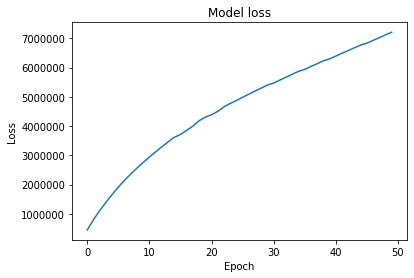

word2vec training complete,epochs:50 using time:45.892441511154175 seconds


[('110339', 0.653994083404541),
 ('71981', 0.5977658033370972),
 ('25485', 0.5974366068840027),
 ('4366', 0.5942772626876831),
 ('37166', 0.5938936471939087),
 ('34569', 0.5925248861312866),
 ('13168', 0.5915049314498901),
 ('24181', 0.5854678153991699),
 ('26626', 0.5841189622879028),
 ('86638', 0.5829948782920837)]

In [4]:
#训练词向量
w2v_model = make_w2v_model('query_title.txt','word2vec.model',epochs=50)
w2v_model.wv.most_similar('1')

In [ ]:
#训练段落向量
d2v_model = make_d2v_model('query_title.txt','doc2vec.model',epochs = 3)

In [18]:
#对词向量、段落向量进行读取
w2v_model = Word2Vec.load("word2vec.model")
d2v_model = Doc2Vec.load('doc2vec.model')

In [21]:

#词向量模型 继续训练（gensim继续训练的话，学习率会重新从默认值0.25开始，再慢慢掉到min_alpha，所以最好不要使用继续训练）
my_call = train_log_word('word2vec.model')
w2v_model.train(corpus_file='query_title.txt',
total_words=w2v_model.corpus_total_words,
epochs=10, 
compute_loss =True,
callbacks=[my_call])

# 观察最后一轮训练loss
print(w2v_model.get_latest_training_loss())

1480384.125
Epoch 1 using time 0.9295544624328613 seconds
loss: 112092.2890625
Epoch 2 using time 0.9295587539672852 seconds
loss: 220170.96875
Epoch 3 using time 1.1598973274230957 seconds
loss: 327874.28125
Epoch 4 using time 1.30155348777771 seconds
loss: 433103.375
Epoch 5 using time 1.2796061038970947 seconds
loss: 535727.25
Model word2vec.model save done!
Epoch 6 using time 1.3065037727355957 seconds
loss: 635215.9375
Epoch 7 using time 1.2975690364837646 seconds
loss: 734141.1875
Epoch 8 using time 1.3134841918945312 seconds
loss: 830791.6875
Epoch 9 using time 1.3154809474945068 seconds
loss: 926942.4375
Epoch 10 using time 1.2047746181488037 seconds
loss: 1022488.5
Model word2vec.model save done!
1022488.5


In [29]:
#特征1（1*2）：一句话中是否有重复的字词
#注意：query和title分开使用
def is_repeat(filename,outputfile,length):
    with open(outputfile, 'w') as output:
        with open(filename) as f:
            #处理开始时间
            start_time = time.time()
            for i in tqdm(range(length),mininterval=1.0):
                key = 0
                line = np.array(f.readline().strip('\n').split(' '))
                #np.unique去重复值
                line2 = np.unique(line)
                if(len(line)>len(line2)):
                    key = 1
                output.write("{0}\n".format(key))
            print("complete, using time "+str(time.time()-start_time)+" seconds")
    return True

#调用该函数
is_repeat('query.txt','query_repeat.txt',length = 20000)

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 41664.68it/s]


complete, using time 0.4870436191558838 seconds


True

In [7]:
#特征2（3）：普通长度特征
#长度特征生成方法，传入csv源文件,输出文件名，得到长度特征（包括query、title长度和它们的长度比）
def len_feature(filename,outfile):
    with open(outfile, 'w') as output:
        with open(filename) as csv_file:
            #处理开始时间
            start_time = time.time()
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in tqdm(csv_reader,mininterval=1.0):
                #第一种方法，稍慢
                #from tensorflow import keras
                #len_query = len(keras.preprocessing.text.text_to_word_sequence(row[1],filters='',lower=True,split=' '))
                #len_title = len(keras.preprocessing.text.text_to_word_sequence(row[3],filters='',lower=True,split=' '))
                #第二种方法，第二种更快，但似乎占用内存更多，不过本来就是行流式读取，内存占用仍然很小
                len_query = len(row[1].split(' '))
                len_title = len(row[3].split(' '))
                len_bi = len_query/len_title
                output.write("{0},{1},{2}\n".format(len_query,len_title,len_bi))
            print("make feature from "+filename+" using time "+str(time.time()-start_time)+" seconds")
    return True

#调用该函数
len_feature("train.csv",'len_feature.txt')

20000it [00:00, 211090.45it/s]


make feature from train.csv using time 0.09774017333984375 seconds


True

In [3]:
#特征3（6*2）：一句话中的tfidf信息——平均值、最大值、最小值、数学期望、方差、中位数
#得到corpus_tfidf，即词-tfidf的内容。输入train+query的文件，返回corpus_tfidf
#注意：title使用，query_title使用
def get_corpus_tfidf(filename):
    sentence = LineSentence(filename)
    dictionary = corpora.Dictionary(sentence)

    #过滤掉频率最高的N个单词
    #dictionary.filter_n_most_frequent(10) 
    #1.去掉出现次数低于no_below的 2.去掉出现次数高于no_above的。注意这个小数指的是百分数 3.在1和2的基础上，保留出现频率前keep_n的单词
    dictionary.filter_extremes(no_below=2,keep_n=len(dictionary))
    #生成corpus
    corpus = [dictionary.doc2bow(text) for text in sentence]

    # 初始化tfidf
    tfidf = models.TfidfModel(corpus)
    # 转换整个词库
    corpus_tfidf = tfidf[corpus]
    #corpus_tfidf.save('corpus_tfidf.txt')
    return corpus_tfidf

#得到tfidf的common feature，输入一个corpus_tfidf，输出到文件中
def tfidf_common_feature(corpus_tfidf,outputfile):
    start_time = time.time()
    with open(outputfile, 'w') as output:
        j = 0
        for i in tqdm(corpus_tfidf,mininterval=1.0):
        #if j ==5426:
            #print(i)
            need = np.array(i).T[1]
            mean = need.mean()
            nmax = need.max()
            nmin = need.min()
            #方差
            var = np.var(need)
            #数学期望
            Ex = np.sum(need)
            #中位数
            middle = np.median(need)
            output.write("{0},{1},{2},{3},{4},{5}\n".format(mean,nmax,nmin,var,Ex,middle))
            j +=1
            
    print("complete, using time "+str(time.time()-start_time)+" seconds")                
    return True

#调用函数
corpus_tfidf = get_corpus_tfidf(r'query_title.txt')
tfidf_common_feature(corpus_tfidf,'tfidf_common_feature.txt')

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 6879.36it/s]


complete, using time 2.91686749458313 seconds


True

In [11]:
#特征4(9)：词向量计算出的段落向量与段落向量的距离
#参数说明：词向量和段落向量的模型名，语料文件名和输出文件名
def w2v_d2v_distance(w2vmodel,d2vmodel,corfile,outputfile):
    #d2vmodel = Doc2Vec.load(d2v_model)
    with open(outputfile, 'w') as output:
        with open(corfile) as csv_file:
            start_time = time.time()
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in tqdm(csv_reader,mininterval=1.0):
                #返回具体行数的段落向量
                d2v = d2vmodel.docvecs[line_count]
                words = row[0].split(' ')
                #创建300维的空np.array
                w2v = np.zeros(300,dtype=float)
                wl=len(words)
                for word in words:
                    w2v = np.add(w2v,w2vmodel.wv[word])
                    
                #取词向量的平均
                w2v = w2v/wl
                
                #计算欧氏距离   （np.subtract:求差，np.square：平方）
                eudi_dis = np.sqrt(np.sum(np.square(np.subtract(w2v,d2v))))
                #计算cos距离     （np.vpot：点积）
                cos_dis = np.vdot(w2v,d2v)/(np.sqrt(np.sum(np.square(w2v)))*np.sqrt(np.sum(np.square(d2v))))
                #曼哈顿距离      (np.abs：绝对值)
                mht_dis = 1.0/(1.0+np.sum(np.abs(np.subtract(w2v,d2v))))
                #相异度距离
                BC_dis = distance.braycurtis(w2v,d2v)
                #坎贝拉距离
                cb_dis = distance.canberra(w2v,d2v)
                #皮尔森相关系数
                corela = distance.correlation(w2v,d2v)
                #海明距离(useless)
                ham_dis= distance.hamming(w2v,d2v)
                #杰卡德距离(useless)
                jc_dis= distance.jaccard(w2v,d2v)
                #方差加权距离
                sqeudi_dis = distance.sqeuclidean(w2v,d2v)

                
                output.write("{0},{1},{2},{3},{4},{5},{6},{7},{8}\n".format(eudi_dis,cos_dis,mht_dis,BC_dis,cb_dis,corela,ham_dis,jc_dis,sqeudi_dis))
                line_count +=1
            print("calculated distance feature with "+ str(line_count)+" lines, using time "+str(time.time()-start_time)+" seconds")
    return True

w2v_d2v_distance(w2v_model,d2v_model,"query_title.txt","w2v_d2v_distance.txt")

20000it [00:04, 4081.38it/s]


calculated distance feature with 20000 lines, using time 4.905137300491333 seconds


True

In [21]:
#特征5（3）：词向量的相似度矩阵（如果算力充足，甚至可以给title.txt也进行单独计算）
#参数说明：传入词向量模型，语料文件名，输出文件名
def w2v_sim_mat(w2vmodel,corfile,outputfile):
    with open(outputfile, 'w') as output:
        with open(corfile) as csv_file:
            start_time = time.time()
            csv_reader = csv.reader(csv_file, delimiter=',')
            #csv_reader可以用来读以空格作为分隔符的txt文件
            for row in tqdm(csv_reader,mininterval=1):
                #row此时是一个列表，只包含一个字符串
                words = row[0].split(' ')
                words_len = len(words)
                #空矩阵
                sim_mat = np.zeros((words_len,words_len))
                #算法优化：遍历上三角矩阵，其他取对称
                for i in range(words_len):
                    for j in range(i,words_len):
                        sim_mat[i][j] = w2vmodel.wv.similarity(words[i],words[j])#返回一个数（相似度）
                        #sim_mat[i][j] = np.vdot(w2vmodel[words[i]],w2vmodel[words[i]])/(np.sqrt(np.sum(np.square(w2vmodel[words[i]])))*np.sqrt(np.sum(w2vmodel[words[j]])))
                        sim_mat[j][i] = sim_mat[i][j]
                #对每一行取平均值，返回一个一维数组
                sim_mean = np.mean(sim_mat, axis=0)
                sim_mean_mean = np.mean(sim_mean,axis=0)
                #相似度矩阵平均值偏度
                sim_mean_skew = stats.skew(sim_mean, axis=0)
                #相似度矩阵平均值峰度
                sim_mean_kurt = stats.kurtosis(sim_mean, axis=0)
                
                #下面是对整个矩阵进行操作，包括整个矩阵的偏度、偏度的平均、偏度的偏度、整个矩阵的峰度、峰度的平均等等（实际因为算力不足未使用）
                #sim_skew = stats.skew(sim_mat, axis=0)
                #sim_skew_mean = np.mean(sim_skew,axis=0)
                #sim_skew_skew = stats.skew(sim_skew, axis=0)
                #sim_kurt = stats.kurtosis(sim_mat, axis=0)
                #sim_kurt_mean = np.mean(sim_kurt,axis=0)
                output.write("{0},{1},{2}\n".format(sim_mean_mean,sim_mean_skew,sim_mean_kurt))
            print("calculated w2v_sim_mat feature using time "+str(time.time()-start_time)+" seconds")
    return True

#调用该函数
w2v_sim_mat(w2v_model,"query_title.txt","w2v_sim_mat_mean.txt")

20000it [01:07, 298.43it/s]


calculated w2v_sim_mat feature using time 67.02113509178162 seconds


True

In [28]:
#特征6（9）：query的平均词向量和title的平均词向量间的距离
#参数说明：传入词向量模型，源csv文件名，输出文件名
def query_title_distance(w2vmodel,corfile,outputfile):
    with open(outputfile, 'w') as output:
        with open(corfile) as csv_file:
            start_time = time.time()
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count=0
            for row in tqdm(csv_reader,mininterval=1.0):
                query = row[1].split(' ')
                title = row[3].split(' ')
                query_len = len(query)
                title_len = len(title)
                query_w2v = np.zeros(300,dtype=float)
                title_w2v = np.zeros(300,dtype=float)
                for word in query:
                    query_w2v = np.add(query_w2v,w2vmodel.wv[word])
                for word in title:
                    title_w2v = np.add(title_w2v,w2vmodel.wv[word])
                query_w2v/=query_len
                title_w2v/=title_len
                
                #计算欧氏距离   （np.subtract:求差，np.square：平方）
                eudi_dis = np.sqrt(np.sum(np.square(np.subtract(query_w2v,title_w2v))))
                #计算cos距离     （np.vpot：点积）
                cos_dis = np.vdot(query_w2v,title_w2v)/(np.sqrt(np.sum(np.square(query_w2v)))*np.sqrt(np.sum(np.square(title_w2v))))
                #曼哈顿距离      (np.abs：绝对值)
                mht_dis = 1.0/(1.0+np.sum(np.abs(np.subtract(query_w2v,title_w2v))))
                #相异度距离
                BC_dis = distance.braycurtis(query_w2v,title_w2v)
                #坎贝拉距离
                cb_dis = distance.canberra(query_w2v,title_w2v)
                #皮尔森相关系数
                corela = distance.correlation(query_w2v,title_w2v)
                #海明距离(useless)
                ham_dis= distance.hamming(query_w2v,title_w2v)
                #杰卡德距离(useless)
                jc_dis= distance.jaccard(query_w2v,title_w2v)
                #方差加权距离
                sqeudi_dis = distance.sqeuclidean(query_w2v,title_w2v)

                
                output.write("{0},{1},{2},{3},{4},{5},{6},{7},{8}\n".format(eudi_dis,cos_dis,mht_dis,BC_dis,cb_dis,corela,ham_dis,jc_dis,sqeudi_dis))
            print("calculated query&title distance feature using time "+str(time.time()-start_time)+" seconds")
    return True
            
#调用该函数
query_title_distance(w2v_model,"train.csv","query_title_dis.txt")

20000it [00:04, 4061.47it/s]


calculated query&title distance feature using time 4.928260087966919 seconds


In [54]:
#特征7（1*2）：tfidf矩阵奇异值分解降维+预测（注：如果算力够，可以把title.txt单独拉出来也进行操作）
#tfidf矩阵奇异值分解降维
#参数说明：传入query和title的组合，输出文件名，需要分解至的维数
def make_tf_idf_svd(corfile,outputfile,dim):
    with open(outputfile, 'w') as output:
        with open(corfile) as cor:
            start = time.time()
            #读取所有行组成大列表
            train_cor = cor.readlines()
            #生成字典
            count_vect = CountVectorizer()
            train_counts = count_vect.fit_transform(train_cor)
            #生成tfidf
            tfidf_transformer = TfidfTransformer()
            train_tfidf = tfidf_transformer.fit_transform(train_counts)
            #降维，需要30维
            lsa = TruncatedSVD(dim) 
            tfidf_svd = lsa.fit_transform(train_tfidf)
            
            for i in tqdm(range(len(tfidf_svd)),mininterval=1.0):
                #转换一下格式，使得成为逗号分隔符
                need = str(list(tfidf_svd[i])).replace(' ','')[1:-1]
                output.write("{0}\n".format(need))
            print("using time :"+str(time.time()-start))
    return True

#调用该函数
make_tf_idf_svd("query_title.txt","tfidf_svd.txt",30) 

#用分解完了的特征向量，加上简单的分类器进行初步预测,预测值（lr和mh）作为特征
#参数说明：上面分解完30维文件，标签，输出的文件名以及需要的（行数）
def make_tfidf_predict(tfidffile,labelfile,outputfile,length):
    with open(outputfile, 'w') as output:
        with open(tfidffile) as train_data:
            with open(labelfile) as label_data:
                start = time.time()
                train_x = []
                #读进30维的训练数据
                for i in tqdm(range(length),mininterval=1.0):
                    train_x.append(list(map(float,train_data.readline().replace('\n','').split(','))))
                train_y = []
                #读进标签数据
                for i in tqdm(range(length),mininterval=1.0):
                    train_y.append(float(label_data.readline()))
                #简单分类器，使用它分别输出lr和mh，损失函数分别为'log'和'modified_huber'
                clf = SGDClassifier(loss='modified_huber',early_stopping=True)
                clf.fit(train_x,train_y)
                #进行预测
                pred = clf.predict_proba(train_x)
                for result in tqdm(pred,mininterval=1.0):
                    #result[1]取正向频率
                    output.write("{0}\n".format(result[1]))
            print("using time :"+str(time.time()-start))
            return True

#调用该函数
make_tfidf_predict('tfidf_svd.txt','lb.txt','tfidf_MH.txt',20000)




  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 30893.36it/s]

using time :1.5665664672851562





  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 50027.90it/s]


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 1061164.06it/s]

[[0.69118564 0.30881436]
 [0.70821263 0.29178737]
 [0.70429092 0.29570908]
 ...
 [0.7534714  0.2465286 ]
 [0.75718997 0.24281003]
 [0.73717936 0.26282064]]





  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 384025.20it/s]

using time :0.5971519947052002


True